# Prediction of precursors

We want to use the information extracted from synthesis papers to infer the precursors we could use for a specific target. The way we approach the problem may lead to different biases as we can implicitly assume some hypothesis. In particular, we are interested in the tag "all_common" of our database i.e. whether a target has been synthesized using only common precursors or not. We need to be careful about one point : it is not because one paper used a non common precursor than the material cannot be made using a common one. In other terms, a non-realization in our data does not mean the impossiblity to do the reaction. However, we can assume that an experimentalist will synthesize a material in a way that will be easiest for them. For example, the precursors can be already available in the lab or using a specific chemical group will lead to fewer synthesis steps. In this notebook, considering a target and a specific set of precursors, we try to predict how easy the corresponding recipe will be.

To generate the data, we consider all the recipes in our database to be easiest. In the case where non common precursors were used, we artificially generate negative reactions with the most common precursors for each metal brought in the target as we consider that these reactions could be less easy than the original ones. Building that way, we can go back to the original problem which was the prediction of the "all_common" tag by only considering the reactions in the data with only common precursors.

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
# Libraries
import json
import numpy as np
from chemical_groups import *
from material_parser import MaterialParser
import plotly.plotly as py
from plotly.offline import iplot
import plotly.graph_objs as go
from tool.preprocess_formulas import PreprocessMaterials
from tool.encode_materials import EncoderTool
from itertools import permutations, product
from pprint import pprint
from imblearn.over_sampling import SMOTE 
from sklearn.externals import joblib

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

Using TensorFlow backend.


In [3]:
# Global variables
with open('elements.txt', 'r') as f:
    elements = json.load(f)

elts2indx = {}
indx2elts = {}
for i, el in enumerate(elements):
    elts2indx[el] = i
    indx2elts[i] = el

classes = {'simple_oxide': 0, 'complex_oxide': 1, 'carbonate': 2, 'nitrate': 3, 'sulfate': 4, 'hydroxide': 5,
           'halide': 6, 'other': 7, 'none': 8}
inv_classes = {v: k for k, v in classes.items()}

In [4]:
# Some functions
with open('most_common_precursor.json', 'r') as f:
    most_common = json.load(f)

In [5]:
def main_element(m):
    '''Return the "main" element of a precursor i.e. element with highest molecular rank except 0, H, C, N'''
    parser = MaterialParser()
    elts = parser.get_chemical_structure(m)['composition'].keys()
    max_el, max_Z = '', 0
    for el in elts:
        if elts2indx[el] > max_Z and el not in ['H', 'C', 'N', 'O']:
            max_el = el
            max_Z = elts2indx[el]
    return max_el

def is_uncommon(groups, main_elts):
    results = [0] * len(main_elts)
    for i in range(len(main_elts)):
        try:
            if classes[most_common[main_elts[i]]] != groups[i]:
                results[i] = 1
        except:
            pass
    return results

def most_common_classes(target):
    parser = MaterialParser()
    composition = parser.get_chemical_structure(target)['composition']
    main_elements = [element for element in composition.keys() if element not in ['H', 'C', 'N', 'O']]
    main_elements = [element for element in reversed(sorted(main_elements))]
    return [classes[most_common[el]] for el in main_elements]

def return_main_elements(target):
    parser = MaterialParser()
    composition = parser.get_chemical_structure(target)['composition']
    main_elements = [element for element in composition.keys() if element not in ['H', 'C', 'N', 'O']]
    main_elements = [element for element in reversed(sorted(main_elements))]
    return main_elements

def comp_to_key(comp):
    elements = sorted([k for k in comp.keys()])
    return ''.join([el + str(comp[el]) for el in elements])

## A look at the recipes: distribution of most common precursors and chemical groups in the recipes
**Nota bene:** In the following figures, only one recipe is considered per DOI - 5 precursors max. per recipe - each element in the target is brought by one and only one precursor.
**7811** recipes are considered.

In [6]:
# Some data
with open('distribution_precursors.json', 'r') as f:
    data = json.load(f)
    
distribution_precursors = data[0]
most_common_element = data[1]

In [ ]:
ratio_common = {}
for el in most_common_element:
    ratio_common[el] = most_common_element[el][0] / most_common_element[el][1]
    
elements_plot = [e for e in ratio_common.keys()]
ratio_plot = [ratio_common[e] for e in elements_plot]
labels = [most_common_element[e][1] for e in elements_plot]
sort_indices_by_ratio = np.argsort(-np.array(ratio_plot))
ratio_plot = np.array(ratio_plot)[sort_indices_by_ratio]
elements_plot = np.array(elements_plot)[sort_indices_by_ratio]
labels = np.array(labels)[sort_indices_by_ratio]
data = [go.Bar(x=elements_plot, y=ratio_plot, text=labels)]
fig = go.FigureWidget(data)
fig.layout.xaxis = dict(title='"Main" element brought by the precusor"')
fig.layout.yaxis = dict(title='(# most common precursors / # precursors)')
fig.layout.title = 'Distribution of the ratio (# most common precursors / # precursors) for all elements'
fig

<img src="notebook_plot1.png">

We represent the distribution of the following chemical groups among the precursors used in our Recipes database: simple oxide, complex oxide, carbonate, sulfate, nitrate, hydroxide, halide and others.

In [8]:
classes_plot = [c for c in distribution_precursors['Cu'].keys()]
elements_plot = [e for e in ratio_common.keys()]
nb_recipes = [np.sum([distribution_precursors[el][c] for c in classes_plot]) for el in elements_plot]
sort_indices_by_ratio = np.argsort(-np.array(nb_recipes))
elements_plot = np.array(elements_plot)[sort_indices_by_ratio]
traces = []
for c in classes_plot:
    y_c = []
    for el in elements_plot:
        y_c.append(distribution_precursors[el][c])
    traces.append(go.Bar(x=elements_plot, y=y_c, name=c.replace('_', ' ')))
fig = go.FigureWidget(data=traces)
fig.layout.barmode = 'stack'
fig.layout.xaxis = dict(title='"Main" element brought by the precusor"')
fig.layout.yaxis = dict(title='Nb of occurences')
fig.layout.title = 'Distribution of the main chemical groups among each precursor'
fig.layout.height = 700
fig

FigureWidget({
    'data': [{'name': 'simple oxide',
              'type': 'bar',
              'uid': '5c6f61…

In [10]:
max_ratio_halide = 0
for el in elements_plot:
    a = distribution_precursors[el]['halide'] / most_common_element[el][1]
    if a > max_ratio_halide:
        max_ratio_halide = a
print('Maximum ratio of halide precursors among all the elements:', max_ratio_halide)

Maximum ratio of halide precursors among all the elements: 3.0


It also does not seem to be relevant to consider halides as a separate group as they never represent more than $3\%$ of the precursors for every element.

## Closer look at the precursors
We decide to use the embedding obtained by the VAE to represent the precursors and this representation contains information about the composition and the chemical group of the materials.
### Impact of the chemical group on the precursors representation

In [5]:
# Load recipes
with open('recipes_db_2407.json', 'r') as f:
    recipes = json.load(f)

In [12]:
# precursors_per_element = {}
# all_precursors = []
# all_precursors_string = []
# for recipe in recipes:
#     precursors = [comp_to_key(p) for p in recipe['precursors']]
#     precursors_main_elements = [return_main_elements(p) for p in precursors]
#     for i, p in enumerate(precursors):
#         try:
#             el = precursors_main_elements[i][0]
#             if el not in precursors_per_element:
#                 precursors_per_element[el] = [p]
#                 all_precursors.append(p)
#                 all_precursors_string.append(recipe['precursors_string'][i])
#             else:
#                 if p not in precursors_per_element[el]:
#                     precursors_per_element[el] = precursors_per_element[el] + [p]
#                     all_precursors.append(p)
#                     all_precursors_string.append(recipe['precursors_string'][i])
#         except:
#             print('Problem with precursors:', precursors)

In [13]:
# with open('notebook_precursors_data.json', 'w') as f:
#     json.dump([precursors_per_element, all_precursors, all_precursors_string], f)

In [ ]:
with open('notebook_precursors_data.json', 'r') as f:
    data = json.load(f)
    
precursors_per_element, all_precursors, all_precursors_string = data[0], data[1], data[2]

In [15]:
print(len(all_precursors_string), 'different precursors in considered recipes.')

1049 different precursors in considered recipes.


In [10]:
# Other embedding
import tool.encode_materials
encoder = EncoderTool(n=3, split=True, reduced=True, energy=True)
precursors_embedding = encoder.transform(all_precursors_string)
print(precursors_embedding.shape)

/Users/nmingione/Documents/VAE/tool/preprocess_formulas.py:39: RuntimeWarning:

divide by zero encountered in true_divide

/Users/nmingione/Documents/VAE/tool/preprocess_formulas.py:39: RuntimeWarning:

invalid value encountered in true_divide

/Users/nmingione/Documents/VAE/tool/preprocess_formulas.py:46: RuntimeWarning:

divide by zero encountered in double_scalars



Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


(1049, 100)


In [11]:
precursors_embedding = np.nan_to_num(precursors_embedding)

In [12]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=15, n_iter=20000)
reduced_embedding = tsne.fit_transform(precursors_embedding)

In [13]:
precursors_groups = [return_chemical_group(p, precursor=True) for p in all_precursors_string]
precursors_groups = [p if p != 'halide' else 'other' for p in precursors_groups]

In [ ]:
traces = []
color_groups = {'simple_oxide': 'blue', 'complex_oxide': 'orange', 'carbonate': 'green', 'nitrate': 'purple', 
                'sulfate': 'red', 'hydroxide': 'pink', 'other': 'gray'}
for group in color_groups:
    points = []
    labels = []
    for i in range(len(all_precursors_string)):
        if precursors_groups[i] == group:
            points.append(reduced_embedding[i])
            labels.append(all_precursors_string[i])
    points = np.array(points)
    traces.append(go.Scatter(
                        x = points[:,0],
                        y = points[:,1],
                        mode='markers',
                        name=group.replace('_',' '),
                        marker=dict(
                            size=6,
                            color=color_groups[group]
                        ),
                        text=labels
                        ))

fig = go.FigureWidget(traces)
fig.layout.title = '2D representation of precursors - dim=100 embedding'
fig.layout.hovermode = 'closest'
fig.layout.xaxis= dict(
        title= 'Feature 1',
        ticklen= 5,
        zeroline= False,
        gridwidth= 2,
    )
fig.layout.yaxis=dict(
        title= 'Feature 2',
        ticklen= 5,
        gridwidth= 2,
    )
fig.layout.showlegend= True
fig.layout.width=1000
fig.layout.height=1000
fig

<img src="newplot.png">

These embeddings of precursors already seem to contain enough information about the chemical group as we can observe some clusters for each chemical groups. This representation also allows us to see the list of all the precursors involved in our recipes database. We can note that there are some errors in some precursors formulas e.g. the cluster $X(NO)_3$ for $X = Lu, Nd, Sr, Co, Ga$ which should likely be instead $X(NO_3)_y$.

## Build dataset
### Filter recipes

Let's build our vectors $X$ and $y$. We consider the recipes with the following conditions:
* 1 recipe per DOI per chemical system
* at most 5 precursors
* each metal in the target is brought by one and only one precursor
* no phosphorus in target (what is the most common class?)

In [7]:
recipes[0].keys()

dict_keys(['version', 'doi', 'year', 'target_string', 'target', 'precursors_string', 'precursors', 'target_elements', 'precursors_elements', 'all_simple', 'all_common', 'operations', 'aqueous_mix', 'simple_mix', 'one_step', 'firing_step', 'all_common_v2', 'target_embeddings', 'weight', 'energy_vae', 'key', 'target_embeddings_energy', 'transition_metal_ionic_radius_diff_max_avg', 'transition_metal_ionic_radius_minimum', 'transition_metal_ionic_radius_maximum', 'transition_metal_ionic_radius_range', 'transition_metal_oxid_states_mean', 'transition_metal_oxid_states_diff_min_avg', 'depth_hulls_minimum_N-1', 'depth_hulls_mean_N-1', 'depth_hulls_ratio_min_avg_N-1', 'depth_hulls_minimum_N-2', 'depth_hulls_mean_N-2', 'depth_hulls_ratio_min_avg_N-2', 'matminer_embedding'])

In [8]:
def bij_precursors_target(target, precursors):
    T = return_main_elements(target)
    P = [main_element(p) for p in precursors]
    return len(T) == len(P) and len(set(T) ^ set(P)) == 0

In [9]:
dois = {}
recipes_filtered = []
for recipe in recipes:
    target = comp_to_key(recipe['target'])
    precursors = recipe['precursors_string']
    try:
        if bij_precursors_target(target, precursors): # each metal in the target is brought by one and only one precursor
            if len(precursors) <= 5 and 'P' not in target: # max 5 precursors and no P because not present in the list of most common precursors
                doi = recipe['doi']
                all_common = recipe['all_common_v2']
                chemical_system = ''.join(sorted([el for el in recipe['target'].keys()]))
                if doi in dois.keys(): # one recipe per DOI per chemical system   
                    if chemical_system in dois[doi]:
                        continue
                    else:
                        dois[doi] = dois[doi] + [chemical_system]
                else:
                    dois[doi] = [chemical_system]
                recipes_filtered.append({
                    'target': target,
                    'precursors': precursors,
                    'all_common': all_common,
                    'doi': doi
                })
    except Exception as e:
        print('Problem with', target, '-', str(e))

Problem with Cl4O8Si3Sr4 - 'A'


In [10]:
with open('notebook_precursors_prediction_recipes_filtered.json', 'w') as f:
    json.dump(recipes_filtered, f)

In [11]:
print('Initial dataset:', len(recipes), 'recipes.')
print('After filter:', len(recipes_filtered), 'recipes.')

Initial dataset: 16613 recipes.
After filter: 7067 recipes.


### Use embeddings for precursors and targets

In [12]:
def normalize_precursors(p):
    parser = MaterialParser()
    return comp_to_key(parser.get_chemical_structure(p)['composition'])

In [80]:
# Build map key <-> embeddings for precursors
# encoder = EncoderTool(split=True, old=True, n=3)
encoder = EncoderTool(n=3, split=True, reduced=True, energy=True)
precursors_filtered = []
for recipe in recipes_filtered:
    for p in recipe['precursors']:
        n_p = normalize_precursors(p)
        if n_p not in precursors_filtered:
            precursors_filtered.append(n_p)
print(len(precursors_filtered), 'precursors.')
all_precursors_embedding = encoder.transform(materials=precursors_filtered)
precursors_embedding = {}
for i, p in enumerate(precursors_filtered):
    key = normalize_precursors(p)
    precursors_embedding[key] = all_precursors_embedding[i]
print(len(precursors_embedding), 'different precursors have been encoded.')

335 precursors.
335 different precursors have been encoded.


In [83]:
for p in precursors_embedding:
    try:
        precursors_embedding[p] = precursors_embedding[p].tolist()
    except:
        pass
with open('notebook_precursors_prediction_key_precursors_100energy.json', 'w') as f:
    json.dump(precursors_embedding, f)

In [16]:
def find_corresponding_recipes(target, old_recipes):
    for recipe in old_recipes:
        if target == comp_to_key(recipe['target']):
            return recipe
    return None

In [46]:
recipes[0].keys()

dict_keys(['version', 'doi', 'year', 'target_string', 'target', 'precursors_string', 'precursors', 'target_elements', 'precursors_elements', 'all_simple', 'all_common', 'operations', 'aqueous_mix', 'simple_mix', 'one_step', 'firing_step', 'all_common_v2', 'target_embeddings', 'weight', 'energy_vae', 'key', 'target_embeddings_energy', 'transition_metal_ionic_radius_diff_max_avg', 'transition_metal_ionic_radius_minimum', 'transition_metal_ionic_radius_maximum', 'transition_metal_ionic_radius_range', 'transition_metal_oxid_states_mean', 'transition_metal_oxid_states_diff_min_avg', 'depth_hulls_minimum_N-1', 'depth_hulls_mean_N-1', 'depth_hulls_ratio_min_avg_N-1', 'depth_hulls_minimum_N-2', 'depth_hulls_mean_N-2', 'depth_hulls_ratio_min_avg_N-2', 'matminer_embedding'])

In [128]:
# Build map key <-> embeddings for targets
for recipe in recipes_filtered:
    t = recipe['target']
    old_recipe = find_corresponding_recipes(t, recipes)
    if old_recipe is not None:
        targets_embeddings[normalize_precursors(t)] = {
            'vae': np.mean(np.array(old_recipe['target_embeddings']), axis=0),
            'vae_energy': np.mean(np.array(old_recipe['target_embeddings_energy']), axis=0),
            'matminer': old_recipe['matminer_embedding'],
            'transition_metal_ionic_radius_diff_max_avg': old_recipe['transition_metal_ionic_radius_diff_max_avg'],
            'transition_metal_ionic_radius_maximum': old_recipe['transition_metal_ionic_radius_maximum'],
            'transition_metal_ionic_radius_minimum': old_recipe['transition_metal_ionic_radius_minimum'],
            'transition_metal_ionic_radius_range': old_recipe['transition_metal_ionic_radius_range'],
            'transition_metal_oxid_states_mean': old_recipe['transition_metal_oxid_states_mean'],
            'transition_metal_oxid_states_diff_min_avg': old_recipe['transition_metal_oxid_states_diff_min_avg'],
            'depth_hulls_minimum_N-1': old_recipe['depth_hulls_minimum_N-1'],
            'depth_hulls_mean_N-1': old_recipe['depth_hulls_mean_N-1'],
            'depth_hulls_ratio_min_avg_N-1': old_recipe['depth_hulls_ratio_min_avg_N-1'],
            'depth_hulls_minimum_N-2': old_recipe['depth_hulls_minimum_N-2'],
            'depth_hulls_mean_N-2': old_recipe['depth_hulls_mean_N-2'],
            'depth_hulls_ratio_min_avg_N-2': old_recipe['depth_hulls_ratio_min_avg_N-2']
        }
    else:
        print('Did not find', t)
print(len(targets_embeddings), 'different targets.')

3985 different targets.


In [ ]:
with open('notebook_precursors_prediction_key_targets.json', 'w') as f:
    json.dump(targets_embeddings, f)

We can use either composition vectors, VAE or matminer embeddings. We need to run some tests and see which one gives the best result. For the moment, we assign matminer embeddings for targets concatenated with features on depth of the hulls and we use a simpler VAE embeddings for precursors. The reason behind this is that the matminer embedding is "very" high dimensional (> 300) so attributing these features for the target and all the precursors will give a high dimension $X$. It might make the models more difficult to train and it can impair their generalization capacities. This is why we use the VAE embedding for precursors which has a dimension of $100$. In the concatenation of the representations, we order the precursors by decreasing atomic number of the main metal.

In [19]:
def clean_matminer_embeddings(M):
    M = np.nan_to_num(M)
    for i in range(M.shape[0]):
            if str(M[i]).isalpha():
                M[i] = 0
    return M.astype(np.float)

In [81]:
encoding_most_common = {}
for el in most_common['most_common_precursor_material']:
    encoding_most_common[el] = encoder.transform([most_common['most_common_precursor_material'][el]])

In [82]:
N = 0
for el in encoding_most_common:
    norm_common = normalize_precursors(most_common['most_common_precursor_material'][el])
    if norm_common not in precursors_embedding:
        precursors_embedding[norm_common] = encoding_most_common[el]
        precursors_filtered.append(norm_common)
        N += 1
print(N, 'precursors have been added.')

6 precursors have been added.


In [93]:
### When creating negative, need to check if it doesn't already exist (!! several recipes for same target...)
### Add list all_common....
### no permutation but decreasing Z ordering
### and if not, multi categorical

In [144]:
X, y, targets, precursors, real = [], [], [], [], []
targets_not_common = []
N_permutations = 5
for k, recipe in enumerate(recipes_filtered):
    target_embed = clean_matminer_embeddings(targets_embeddings[recipe['target']]['matminer'])
    main_elements_precursors = [main_element(p) for p in recipe['precursors']]
    # order precursors in decreasing number of atomic number
    atomic_number = [-elts2indx[el] for el in main_elements_precursors]
    reordered_index = np.argsort(atomic_number)
    recipe_precursors = [recipe['precursors'][i] for i in reordered_index]
    try:
        # create X = target (matmimer embedding) + 5 precursors (vae 100_energy embedding)
        pred_embed_shape = len(precursors_embedding['Fe1O1'])
        precursors_embed = np.concatenate([precursors_embedding[normalize_precursors(p)] for p in recipe_precursors] +
                                          (5 - len(recipe_precursors)) * [pred_embed_shape * [0]])
        X.append(np.concatenate((target_embed, precursors_embed)))
        y.append(1)
        targets.append(recipe['target'])
        precursors.append([normalize_precursors(p) for p in recipe_precursors])
        real.append(1)
        # if not most common precursor is used, generate new recipes from most_common_precursors list (but add only after checking the same target has not
        # been synthesized with most common precursors in another paper)
        most_common_precursors = []
        for i, p in enumerate(recipe_precursors):
            group = return_chemical_group(p)
            element = main_elements_precursors[reordered_index[i]]
            most_common_precursors.append(group == equiv_classes[most_common['most_common_precursor_class'][element]])
        most_common_recipe = all(most_common_precursors)
        if not most_common_recipe:
            targets_not_common.append(normalize_precursors(recipe['target']))
    except Exception as e:
        print(recipe['target'], '-', str(e))

B1F3Mg3O3 - 'F'
Bi1Cl1O1 - 'Cl'
Se1Sr1 - 'Se'
Ba1O4S1 - 'S'
Al1B1Ba1F2O3 - 'F'
Ca4F2O7Si2 - 'F'
Bi1Cl1O1 - 'Cl'
F1Li2Mn3Ni1O7 - 'F'
F1Li10O79V29Y1 - 'F'
As1K1O9W2 - 'other multicomponent'
As1Bi1Cd2O6 - 'other multicomponent'
Se1Sr1 - 'Se'
F3La55Li33O297Ti100 - 'F'
F1Li1O4Si1Sr2 - 'F'
Cl1Na3O4W1 - 'Cl'
Cl1Mo1Na3O4 - 'Cl'
F183La557Li147O2817Ti1000 - 'F'
I1Tl1 - 'I'
F1Li80O239Ti100 - 'F'
B5Cl1O9Sr2 - 'Cl'
B1O16Rb5S4 - 'S'
Br1Li20Mn40O79 - 'Br'
Gd2O2S1 - 'S'
Br1Li10Mn20O39 - 'Br'
Br1Li20Mn40O79 - 'Br'
Al1Br1Li20Mn39O79 - 'Br'
Cl1Gd1O1 - 'Cl'
Cu2S1 - 'S'
O4S1Sr1 - 'S'
F3Y1 - 'F'
Bi2O5Se1 - 'Se'
Cl1Gd1O1 - 'Cl'


In [146]:
np.save('notebook_precursors_prediction_X2.npy', np.array(X))
np.save('notebook_precursors_prediction_y2.npy', np.array(y))
np.save('notebook_precursors_prediction_targets2.npy', np.array(targets))
np.save('notebook_precursors_prediction_precursors2.npy', np.array(precursors))
np.save('notebook_precursors_prediction_real2.npy', np.array(real))

In [145]:
# X_tmp, y_tmp, targets_tmp, precursors_tmp, real_tmp = [], [], [], [], []
for k in range(len(targets_not_common)):
    try:
        # Generate most common precursors
        main_elements_precursors = return_main_elements(targets_not_common[k])
        atomic_number = [-elts2indx[el] for el in main_elements_precursors]
        reordered_index = np.argsort(atomic_number)
        reordered_elements = [main_elements_precursors[i] for i in reordered_index]
        common_precursors_recipe = [most_common['most_common_precursor_material'][el] for el in reordered_elements]
        # Generate X, y
        target_embed = clean_matminer_embeddings(targets_embeddings[targets_not_common[k]]['matminer'])
        pred_embed_shape = len(precursors_embedding['Fe1O1'])
        precursors_embed = np.concatenate([precursors_embedding[normalize_precursors(p)] for p in common_precursors_recipe] +
                                          (5 - len(common_precursors_recipe)) * [pred_embed_shape * [0]])
        X.append(np.concatenate((target_embed, precursors_embed)))
        y.append(0)
        targets.append(targets_not_common[k])
        precursors.append(common_precursors_recipe)
        real.append(0)
    except Exception as e:
        print(targets_not_common[k], '-', str(e))

In [ ]:
# X, y, targets, precursors = [], [], [], []
# N_permutations = 5
# for recipe in recipes_filtered:
#     target_embed = clean_matminer_embeddings(targets_embeddings[recipe['target']]['matminer'])
#     prec_permutations = np.random.permutation([k for k in permutations(range(len(recipe['precursors'])))])[:N_permutations]
#     try:
#         for indices in prec_permutations:
#             pred_embed_shape = len(precursors_embedding['Fe1O1'])
#             precursors_embed = np.concatenate([precursors_embedding[normalize_precursors(recipe['precursors'][i])] for i in indices] +
#                                               (5 - len(recipe['precursors'])) * [pred_embed_shape * [0]])
#             X.append(np.concatenate((target_embed, precursors_embed)))
#             y.append(1)
#             targets.append(recipe['target'])
#             precursors.append([normalize_precursors(p) for p in recipe['precursors']])
#         # if not most common precursor is used, generate new recipes from most_common_precursors list
#         for i, p in enumerate(recipe['precursors']):
#             group = return_chemical_group(p)
#             element = main_element(p)
#             if group != return_chemical_group(most_common['most_common_precursor_material'][element]):
#                 new_precursors = [normalize_precursors(most_common['most_common_precursor_material'][element])] + \
#                                  [normalize_precursors(mat) for mat in recipe['precursors'] if mat != p]
#                 prec_permutations = np.random.permutation([k for k in permutations(range(len(new_precursors)))])[:N_permutations]
#                 try:
#                     for indices in prec_permutations:
#                         precursors_embed = np.concatenate([precursors_embedding[new_precursors[i]] for i in indices] +
#                                                           (5 - len(new_precursors)) * [pred_embed_shape * [0]])
#                         X.append(np.concatenate((target_embed, precursors_embed)))
#                         y.append(0)
#                         targets.append(recipe['target'])
#                         precursors.append(recipe['precursors'])
#                 except Exception as e:
#                     print(recipe['target'], '-', str(e))
#                 break
#     except Exception as e:
#         print(recipe['target'], '-', str(e))

In [142]:
# X = np.load('notebook_precursors_prediction_X.npy')
# y = np.load('notebook_precursors_prediction_y.npy')
# targets = np.load('notebook_precursors_prediction_targets.npy')
# precursors = np.load('notebook_precursors_prediction_precursors.npy')

In [148]:
np.array(X).shape

(8100, 871)

The data contains $8100$ observations.

In [149]:
X = np.array(X)
y = np.array(y)
targets = np.array(targets)
precursors = np.array(precursors)

### Divide in train / test set
By defining clusters for materials with same chemical system. We do not want targets with identical chemical groups to belong both to the train set and the test set. We might underestimate the accuracy on the test set that way but targets with same chemical groups will likely be synthesized in the same way so we do not want to be biased in the evaluation of the generalization capicity of the model.

In [150]:
signatures_count = {}
signatures = []
parser = MaterialParser()
for i in range(len(targets)):
    c = parser.get_chemical_structure(targets[i])['composition']
    sign = ''.join(sorted([k for k in c.keys()]))
    signatures.append(sign)
    if sign not in signatures_count:
        signatures_count[sign] = 1
    else:
        signatures_count[sign] = signatures_count[sign] + 1

In [151]:
def return_comp_vector(m):
    parser = MaterialParser()
    comp = parser.get_chemical_structure(m)['composition']
    vector = np.zeros((len(elements),1))
    for el in comp:
        vector[elts2indx[el]] = comp[el]
    z = np.sum(vector)
    if z > 0:
        vector /= z
    return vector

In [152]:
clusters = {}
for i in range(len(signatures)):
    if signatures[i] not in clusters:
        clusters[signatures[i]] = [i]
    else:
        clusters[signatures[i]] = clusters[signatures[i]] + [i]

In [153]:
def separate_two_sets(clusters, ratio, seed=42):
    np.random.seed(seed)
    N_data = 0
    indices_1, indices_2 = [], []
    for sign in clusters:
        N_data += len(clusters[sign])
    chemical_systems = np.random.permutation([k for k in clusters.keys()])
    i_system = 0
    while len(indices_1) / N_data < ratio:
        indices_1 = indices_1 + clusters[chemical_systems[i_system]]
        i_system += 1
    for i in range(i_system, len(chemical_systems)):
        indices_2 = indices_2 + clusters[chemical_systems[i]]
        
    return (indices_1, indices_2)

In [154]:
split = separate_two_sets(clusters, 0.85)
train_indices, test_indices = split[0], split[1]
np.save('notebook_precursors_prediction_indices.npy', [train_indices, test_indices])

In [155]:
len(train_indices)

6940

$6940$ observations in the train set.

In [156]:
train_indices = np.random.permutation(train_indices)

In [157]:
X_train, y_train, targets_train, precursors_train = X[train_indices], y[train_indices], targets[train_indices], precursors[train_indices]

In [160]:
X_test, y_test, targets_test, precursors_test = X[test_indices], y[test_indices], targets[test_indices], precursors[test_indices]

In [163]:
np.where(X_train == -np.inf) # l'attribut 243 est à corriger, supprimons le pour le moment

(array([ 237,  260,  751,  774,  903, 1814, 2099, 2171, 2809, 2841, 3518,
        4709, 4993, 5008, 5228, 5455, 5489, 6053, 6537, 6710]),
 array([243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243,
        243, 243, 243, 243, 243, 243, 243]))

In [164]:
X_train = np.delete(X_train, 243, axis=1)
X_test = np.delete(X_test, 243, axis=1)

In [165]:
X_train.shape

(6940, 870)

In [168]:
np.where(X_train == np.nan)

(array([], dtype=int64), array([], dtype=int64))

In [169]:
# Use SMOTE method to oversample the minority class
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_sample(X_train, y_train)

After separating the set in train set and test set while paying attention to the clusters issue, we artificially augment the train set thanks to the SMOTE method so we have a ratio of positive / negative class of 50 / 50.

In [170]:
print('Resampled train set:', len(X_res))
print('Former train set:', len(X_train))
print('Ratio easy / all recipes:', np.sum(y_res) / len(y_res))

Resampled train set: 12162
Former train set: 6940
Ratio easy / all recipes: 0.5


## Train models

In [171]:
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.externals import joblib

In [172]:
params = {'reg_lambda': 0, 'reg_alpha': 0.0005, 'max_depth': 10, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.6}

model = xgb.XGBClassifier(objective='binary:logistic', n_jobs=4,  n_estimators=1000, eval_set=[(X_test, y_test)],
                          eval_metric='auc', early_stopping_rounds=75, nthread=-1, silent=False)

model.set_params(**params)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, early_stopping_rounds=75, eval_metric='auc',
       eval_set=[(array([[-3.3397 ,  3.66512, ...,  0.     ,  0.     ],
       [-3.3397 ,  3.66512, ...,  0.     ,  0.     ],
       ...,
       [-1.39715,  2.9906 , ...,  0.     ,  0.     ],
       [-1.42299,  2.54426, ...,  0.     ,  0.     ]]), array([1, 1, ..., 0, 0]))],
       gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=4,
       nthread=-1, objective='binary:logistic', random_state=0,
       reg_alpha=0.0005, reg_lambda=0, scale_pos_weight=1, seed=None,
       silent=False, subsample=1)

In [173]:
model.fit(X_res, y_res, verbose=2)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, early_stopping_rounds=75, eval_metric='auc',
       eval_set=[(array([[-3.3397 ,  3.66512, ...,  0.     ,  0.     ],
       [-3.3397 ,  3.66512, ...,  0.     ,  0.     ],
       ...,
       [-1.39715,  2.9906 , ...,  0.     ,  0.     ],
       [-1.42299,  2.54426, ...,  0.     ,  0.     ]]), array([1, 1, ..., 0, 0]))],
       gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=4,
       nthread=-1, objective='binary:logistic', random_state=0,
       reg_alpha=0.0005, reg_lambda=0, scale_pos_weight=1, seed=None,
       silent=False, subsample=1)

In [174]:
joblib.dump(model, 'prec_pred_2.pkl')

['prec_pred_2.pkl']

### Brief look at the predictions

In [15]:
model = joblib.load('prec_pred_2.pkl')

In [ ]:
y_score = model.predict_proba(X_test)[:,1]

In [ ]:
list(zip(y_score[:10], targets_test[:10], y_test[:10], precursors_test[:10]))

In [179]:
np.sum(y_test) / len(y_test)

0.85

The figures here below represent respectively the accuracy of the model, the ROC AUC score and the confusion matrix: 122 true negative predictions, 758 true positive predictions, 228 false negative and 52 false positive predictions.

In [257]:
t = 0.9
y_pred = []
for outcome in y_score:
    if outcome > t:
        y_pred.append(1)
    else:
        y_pred.append(0)
print(accuracy_score(y_test, y_pred))
print(roc_auc_score(y_test, y_score))
print(confusion_matrix(y_test, y_pred))

0.7586206896551724
0.8162988738896273
[[122  52]
 [228 758]]


Let's plot the ROC curve to evaluate the performance of the model and the trade-off precision / recall.

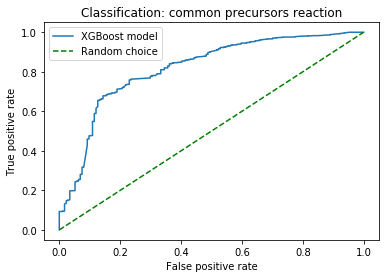

In [184]:
fpr, tpr, threshold = roc_curve(y_test, y_score)
plt.clf()
plt.plot(fpr, tpr, label='XGBoost model')
plt.plot([0.0, 1.0], [0.0, 1.0], 'g--', label='Random choice')
plt.title('Classification: common precursors reaction')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.show()

The farther away the blue curve is from the green dot line, the better the model is comparing to a random choice.

<Figure size 432x288 with 0 Axes>

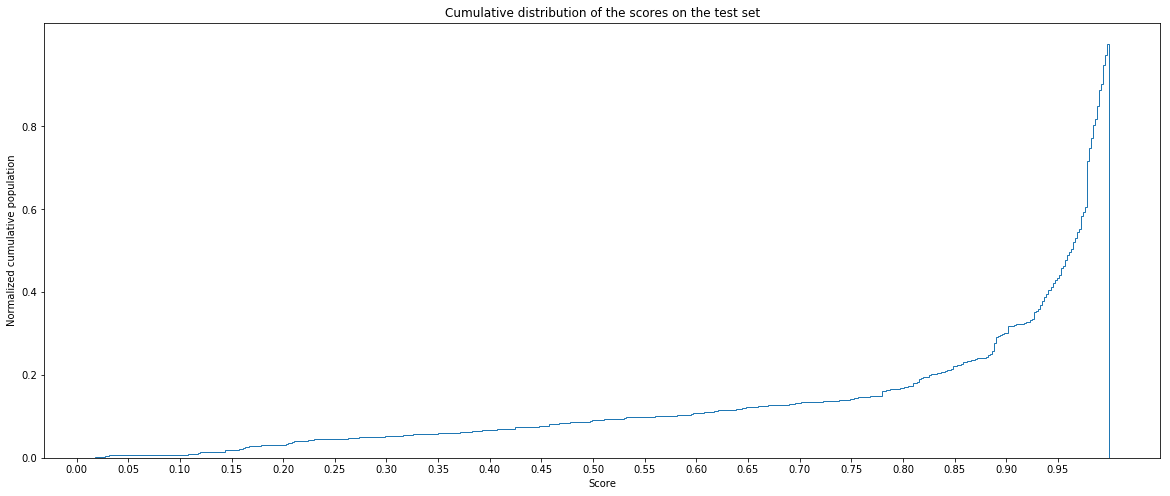

In [258]:
n_bins = 500
plt.clf()
fig = plt.figure(figsize=(20,8))
n, bins, patches = plt.hist(y_score, n_bins, density=1, histtype='step', cumulative=True)
# plt.plot([0,1],[0.2, 0.2],'--')
ax = fig.gca()
ax.set_xticks(np.arange(0, 1, 0.05))
ax.set_yticks(np.arange(0, 1., 0.2))
plt.title('Cumulative distribution of the scores on the test set')
plt.xlabel('Score')
plt.ylabel('Normalized cumulative population')
plt.show()

### All common?

We can go back to the problem of the prediction of the "all_common" tag. To do so, we predict the "easiness" score for the targets considering the most common precursors for each metal. Recipes with "all_common = 1" should be classified as easy in this model and the opposite should hold for recipes with "all_common = 0".

In [197]:
equiv_classes = {'simple oxide': 'simple_oxide', 'multicomponent oxide': 'complex_oxide', 'carbonate': 'carbonate', 'hydroxide': 'other', 'chloride': 'other',
                'sulfate': 'sulfate', 'nitrate': 'nitrate'}

In [200]:
indices_all_common = []
for i in range(len(targets_test)):
    most_common_precursors = []
    for j, p in enumerate(precursors_test[i]):
        group = return_chemical_group(p)
        element = main_element(p)
        try:
            most_common_precursors.append(group == equiv_classes[most_common['most_common_precursor_class'][element]])
        except:
            most_common_precursors.append(False)
    if all(most_common_precursors):
        indices_all_common.append(i)

In [205]:
y_score_ac = model.predict_proba(X_test[indices_all_common])[:,1]

In [260]:
t = 0.92
y_pred_ac = []
for outcome in y_score_ac:
    if outcome > t:
        y_pred_ac.append(1)
    else:
        y_pred_ac.append(0)
        
print('Nb of test points:', len(indices_all_common))
print('Ratio all common / total in test set:', np.sum(y_test[indices_all_common]) / len(indices_all_common))
print('ROC AUC score:', roc_auc_score(y_test[indices_all_common], y_score_ac))
# print('Accuracy:', accuracy_score(y_test[indices_all_common], y_pred_ac))
print('Precision:', precision_score(y_test[indices_all_common],  y_pred_ac))
print('Recall:', recall_score(y_test[indices_all_common],  y_pred_ac))
print('F1 score:', f1_score(y_test[indices_all_common],  y_pred_ac))
c = confusion_matrix(y_test[indices_all_common],  y_pred_ac)
print('Confusion matrix:', c)
print('Accuracy on 1:', c[1,1]/(c[1,1]+c[1,0]))
print('Accuracy on 0:', c[0,0]/(c[0,1]+c[0,0]))

Nb of test points: 939
Ratio all common / total in test set: 0.8679446219382322
ROC AUC score: 0.7717939837720167
Precision: 0.9451219512195121
Recall: 0.7607361963190185
F1 score: 0.8429639700883752
Confusion matrix: [[ 88  36]
 [195 620]]
Accuracy on 1: 0.7607361963190185
Accuracy on 0: 0.7096774193548387


### Prediction precursors by sampling

Can we sample through all the precursors combinations and rank, for a specific target, the recipes by their easiness? The top rank recipes indicate the precursors that we *should* use for synthesizing the material.

In [212]:
sample_precursors = {}
for p in precursors_embedding.keys():
    el = main_element(p)
    if el in sample_precursors:
        sample_precursors[el] = sample_precursors[el] + [p]
    else:
        sample_precursors[el] = [p]

In [268]:
k = 300
target = targets_test[k]
elements_target = return_main_elements(target)
atomic_number = [-elts2indx[el] for el in elements_target]
reordered_index = np.argsort(atomic_number)
elements_target = np.array(elements_target)[reordered_index]
precursors_per_element = [sample_precursors[el] for el in elements_target if return_chemical_group(sample_precursors[el]) != 'other']
print('Target:', targets_test[k])
print('List of possible precursors per element:', precursors_per_element)
precursors_to_test = list(product(*precursors_per_element))
print(len(list(precursors_to_test)), 'combinations of precursors.')
X_s = []
for test in precursors_to_test:
    pred_embed_shape = len(precursors_embedding['Fe1O1'])
    precursors_embed = np.concatenate([precursors_embedding[p] for p in test] +
                                      (5 - len(test)) * [pred_embed_shape * [0]])
    X_s.append(np.concatenate((X_test[k,:371], precursors_embed)))
X_s = np.array(X_s)
X_s = np.delete(X_s, 243, axis=1)

scores_reactions = np.array(model.predict_proba(X_s)[:,1])
indices_rank = (-scores_reactions).argsort()
scores_reactions = scores_reactions[indices_rank]
precursors_to_test = np.array(precursors_to_test)[indices_rank]
X_original = np.concatenate((X_test[k,:371] , np.concatenate([precursors_embedding[normalize_precursors(p)] for p in precursors_test[k]] + \
                                                           (5 - len(precursors_test[k])) * [pred_embed_shape * [0]])))
X_original = np.delete(np.array(X_original).reshape((1, -1)), 243, axis=1)
print('Original precursors:', precursors_test[k], 'with predicted score:', model.predict_proba(X_original)[0,1])
for j in range(10):
    print(precursors_to_test[j], scores_reactions[j])
print('.\n.\n.\n.')
N = len(precursors_to_test)
for j in range(10):
    print(precursors_to_test[N-11+j], scores_reactions[N-11+j])

Target: Al2O4Zn1
List of possible precursors per element: [['O1Zn1', 'H2N26O79Zn1', 'Cl2Zn1', 'C4H6O4Zn1', 'N2O6Zn1', 'C1O3Zn1'], ['Al2O3', 'Al1H3O3', 'Al1N1', 'Al1H1O2', 'Al1N3O9', 'Al4C3', 'Al1H2N3.9O12.7', 'Al1H32.949O31.949', 'Al3H3O3', 'Al1H2N39O118']]
60 combinations of precursors.
Original precursors: ['ZnO', 'Al2O3'] with predicted score: 0.8213888
['H2N26O79Zn1' 'Al1H2N39O118'] 0.9993734
['N2O6Zn1' 'Al1H2N39O118'] 0.99931514
['H2N26O79Zn1' 'Al1N3O9'] 0.99920696
['C1O3Zn1' 'Al1H2N39O118'] 0.99917585
['H2N26O79Zn1' 'Al1H2N3.9O12.7'] 0.99911064
['N2O6Zn1' 'Al1N3O9'] 0.999047
['H2N26O79Zn1' 'Al1H32.949O31.949'] 0.99890304
['N2O6Zn1' 'Al1H2N3.9O12.7'] 0.9988158
['C1O3Zn1' 'Al1N3O9'] 0.9988079
['H2N26O79Zn1' 'Al1H1O2'] 0.99872917
.
.
.
.
['C4H6O4Zn1' 'Al4C3'] 0.97520816
['C4H6O4Zn1' 'Al1N1'] 0.96477073
['O1Zn1' 'Al3H3O3'] 0.9640803
['Cl2Zn1' 'Al4C3'] 0.9569443
['Cl2Zn1' 'Al1N1'] 0.94122803
['C1O3Zn1' 'Al2O3'] 0.94014055
['O1Zn1' 'Al4C3'] 0.93859905
['O1Zn1' 'Al1N1'] 0.9260095
['C4H6

Meh. We could look at other targets.